# 7. Neural networks

The first step is to activate the packages and load the data.

In [1]:
import pyreadr
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression 
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dropout
import tensorflow as tf
from sklearn.cluster import KMeans
np.random.seed(0)

In [3]:
#data_ml = pyreadr.read_r(insert path of data_ml.RData)["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also copy/paste some chunks from Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique() 
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')  
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

Before we head to the core of the NN, a short stage of data preparation is required. The data must be sorted into four parts which are the combination of two dichotomies: training versus testing and labels versus features. We define the corresponding variables below. For simplicity, the first example is a regression exercise. A classification task will be detailed below.


In [5]:
NN_train_features = training_sample[features]
NN_train_labels = training_sample.R1M_Usd
NN_test_features = testing_sample[features]
NN_test_labels = testing_sample.R1M_Usd

Starting from now, we work with the package *keras* which is an adaptation of the Python framework of the same name. You must therefore have a recent version of Python installed.


In [6]:
model = Sequential()
model.add(layers.Dense(16, activation="relu", input_shape = (len(NN_train_features.columns),) ))
model.add(layers.Dense(8, activation="sigmoid"))
model.add(layers.Dense(1))


Each layer depends on two parameters: the number of layers and the activation function that is applied to the output of the layer. One important point is the input_shape parameter for the first layer. It is required for the first layer and is equal to the number of features. For the subsequent layers, the input_shape is dictated by the number of units of the previous layer; hence it is not required. The activations that are currently available are listed on https://keras.io/activations/. 


In [7]:
model.compile(loss='MeanSquaredError',      # Loss function
              optimizer='RMSprop',          # Optimisation method (weight updating)
              metrics='MeanAbsoluteError' ) # Output metric
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1504      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


The final stage fits the model to the data and requires some additional training parameters: 


In [8]:
fit_NN = model.fit(NN_train_features,                                    # Training features
                   NN_train_labels,                                      # Training labels
                  epochs = 10, batch_size = 512,                        # Training parameters           
                  validation_data = (NN_test_features, NN_test_labels)  # Test data
                  )



Epoch 1/10
387/387 [==============================] - 0s 1ms/step - loss: 0.0486 - mean_absolute_error: 0.1160 - val_loss: 0.0370 - val_mean_absolute_error: 0.0668
Epoch 2/10
387/387 [==============================] - 0s 877us/step - loss: 0.0290 - mean_absolute_error: 0.0839 - val_loss: 0.0370 - val_mean_absolute_error: 0.0668
Epoch 3/10
387/387 [==============================] - 0s 903us/step - loss: 0.0290 - mean_absolute_error: 0.0838 - val_loss: 0.0370 - val_mean_absolute_error: 0.0668
Epoch 4/10
387/387 [==============================] - 0s 872us/step - loss: 0.0289 - mean_absolute_error: 0.0838 - val_loss: 0.0371 - val_mean_absolute_error: 0.0672
Epoch 5/10
387/387 [==============================] - 0s 864us/step - loss: 0.0289 - mean_absolute_error: 0.0838 - val_loss: 0.0371 - val_mean_absolute_error: 0.0671
Epoch 6/10
387/387 [==============================] - 0s 859us/step - loss: 0.0289 - mean_absolute_error: 0.0838 - val_loss: 0.0370 - val_mean_absolute_error: 0.0670
Epoch 

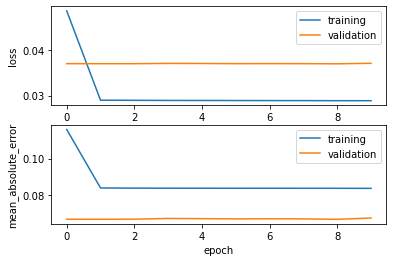

In [9]:
plt.subplot(2,1,1)
plt.plot(fit_NN.history['loss'])
plt.plot(fit_NN.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

plt.subplot(2,1,2)
plt.plot(fit_NN.history['mean_absolute_error'])
plt.plot(fit_NN.history['val_mean_absolute_error'])
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

The batch size is quite arbitrary. For technical reasons pertaining to training on GPUs, these sizes are often powers of 2. 

The prediction is obtained via the usual predict() function. We use this function below on the testing sample to calculate the hit ratio.



In [10]:
print("Hit ratio:", (model.predict(NN_test_features).T *NN_test_labels.to_numpy()>0).mean())

Hit ratio: 0.5457355287146763


We pursue our exploration of neural networks with a much more detailed example. The aim is to carry out a classification task on the binary label R1M_Usd_C. Before we proceed, we need to format the label properly. To this purpose, we resort to one-hot encoding.


In [11]:
NN_train_labels_C  = pd.get_dummies(training_sample.R1M_Usd_C)
NN_test_labels_C = pd.get_dummies(testing_sample.R1M_Usd_C)

The labels NN_train_labels_C and NN_test_labels_C have two columns: the first flags the instances with above median return and the second flags those with below median returns. Note that we do not alter the feature variables: they remain unchanged. Below, we set the structure of the networks with many additional features compared to the first one.


In [12]:
model_C = Sequential()
model_C.add(layers.Dense(16, activation="tanh",                                   # Nb units & activation
                        input_shape=(len(NN_train_features.columns),) ,           # Size of input
                        kernel_initializer='random_normal',                       # Initialization of weights
                        kernel_constraint='non_neg'                               # Weights should be nonneg
                        )
           )
model_C.add(Dropout(0.25))                                                        # Dropping out 25% units
model_C.add(layers.Dense(8, activation="elu",                                     # Nb units & activation 
                        bias_initializer= keras.initializers.Constant(value=0.2), # Initialization of biases
                        kernel_regularizer=keras.regularizers.l2(0.01)            # Penalization of weights 
                        )
           )
model_C.add(layers.Dense(2, activation="softmax"))                                # Softmax for categorical output

The specification of the training is outlined below.


In [13]:
model_C.compile(loss='binary_crossentropy',                                                   # Loss function
              optimizer=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.95), # Optimisation method (weight updating)
              metrics='categorical_accuracy' )                                                # Output metric
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1504      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


Finally, we proceed with the training of the model.


In [14]:
fit_NN_C = model_C.fit(NN_train_features, NN_train_labels_C,                          # Training features& labels
                  epochs = 20, batch_size = 512,                                      # Training parameters
                  validation_data = (NN_test_features, NN_test_labels_C),             # Test data
                       verbose = 0,                                                   # No comments from algo
                       callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',  # Early stopping: 
                           min_delta=0.001,                                           # Improvement threshold
                           patience=3,                                                # Nb epochs with no improvmt 
                           verbose=0 )                                                # No warnings
                      )

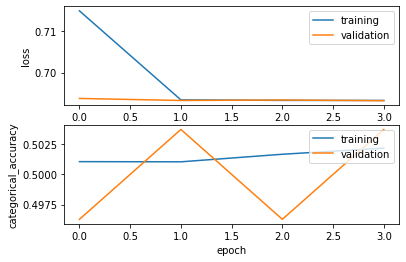

In [15]:
plt.subplot(2,1,1)
plt.plot(fit_NN_C.history['loss'])
plt.plot(fit_NN_C.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

plt.subplot(2,1,2)
plt.plot(fit_NN_C.history['categorical_accuracy'])
plt.plot(fit_NN_C.history['val_categorical_accuracy'])
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

There is only one major difference here compared to the previous training call. In keras, callbacks are functions that can be used at given stages of the learning process. In the above example, we use one such function to stop the algorithm when no progress has been made for some time. 


In [16]:
model_custom = Sequential()
model_custom.add(layers.Dense(16, activation="relu", input_shape = (len(NN_train_features.columns),) ))
model_custom.add(layers.Dense(8, activation="sigmoid"))
model_custom.add(layers.Dense(1))
model_custom.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                1504      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


In [18]:
def custom_loss(y,f):
    y= float(y)                        #To avoid TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float16 of argument 'x'.
    return tf.keras.backend.mean(
         (f - tf.keras.backend.mean(f))**2)  \
         - 5 * tf.keras.backend.mean((y - tf.keras.backend.mean(y))
                                     * (f - tf.keras.backend.mean(f)))
model_custom.compile(loss =custom_loss, # Customized ftn
    optimizer='RMSprop',                # Optim method 
    metrics='MeanAbsoluteError'         # Output metric
)

Finally, we are ready to train and briefly evalute the performance of the model.


In [19]:
fit_NN_cust = model_custom.fit(NN_train_features,NN_train_labels,                                         
        epochs = 10, batch_size = 512,                           
        validation_data = (NN_test_features, NN_test_labels_C)
) 



Epoch 1/10
387/387 [==============================] - 0s 1ms/step - loss: -8.8999e-05 - mean_absolute_error: 0.5009 - val_loss: 0.0010 - val_mean_absolute_error: 0.5000
Epoch 2/10
387/387 [==============================] - 0s 874us/step - loss: -8.1959e-04 - mean_absolute_error: 0.4930 - val_loss: 8.3621e-04 - val_mean_absolute_error: 0.5000
Epoch 3/10
387/387 [==============================] - 0s 866us/step - loss: -9.9707e-04 - mean_absolute_error: 0.5071 - val_loss: 7.3066e-04 - val_mean_absolute_error: 0.5000
Epoch 4/10
387/387 [==============================] - 0s 859us/step - loss: -0.0011 - mean_absolute_error: 0.4955 - val_loss: 9.3262e-04 - val_mean_absolute_error: 0.5000
Epoch 5/10
387/387 [==============================] - 0s 866us/step - loss: -0.0012 - mean_absolute_error: 0.5032 - val_loss: 0.0010 - val_mean_absolute_error: 0.5000
Epoch 6/10
387/387 [==============================] - 0s 856us/step - loss: -0.0013 - mean_absolute_error: 0.5202 - val_loss: 9.8909e-04 - val_

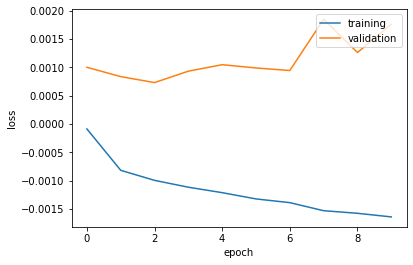

In [20]:
plt.plot(fit_NN_cust.history['loss'])
plt.plot(fit_NN_cust.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')


The curves may go in opposite direction. One reason for that is that while improving correlation between realized and predicted values, we are also increasing the sum of squared predicted returns. 


In [21]:
#To solve memory error I change the code
predict_np = np.where(model_custom.predict(NN_test_features)>0, True, False)
NN_test_labels_np = np.where(NN_test_labels>0, True, False)

print("Hit ratio:", (predict_np==NN_test_labels_np ).mean() )

Hit ratio: 0.5460346399270738


Next, we dive into recurrent networks.

The dimensions  of variables are crucial. In keras, they are defined for RNNs as:

1. The size of the batch. In our case, it will be the number of assets. Indeed, the recurrence relationship holds at the asset level, hence each asset will represent a new batch on which the model will learn.     
2. The timesteps. In our case, it will simply be the number of dates.    
3. The number of features. In our case, there is only one possible figure: the number of predictors. 

First, we create some new, intermediate variables.


In [22]:
data_rnn = data_ml[data_ml['stock_id'].isin(stock_ids_short)]
training_sample_rnn  = data_rnn[data_rnn.date < separation_date]
testing_sample_rnn  = data_rnn[data_rnn.date > separation_date]
nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = len(training_sample) / nb_stocks
nb_dates_test = len(testing_sample) / nb_stocks

Then, we construct the variables we will pass as arguments. We recall that the data file was ordered first by stocks and then by date (see Section \@ref(dataset)).


In [23]:
train_features_rnn = (NN_train_features.to_numpy()[:int(nb_dates_train)*nb_stocks  ]).reshape(int(nb_dates_train),nb_stocks,nb_feats)
train_features_rnn = train_features_rnn.transpose(1, 0, 2)
test_features_rnn =  (NN_test_features.to_numpy()[:int(nb_dates_test)*nb_stocks ] ).reshape(int(nb_dates_test),nb_stocks,nb_feats)
test_features_rnn = test_features_rnn.transpose(1, 0, 2)
train_labels_rnn = (NN_train_labels.to_numpy()[:int(nb_dates_train)*nb_stocks  ]).reshape(int(nb_dates_train),nb_stocks,1)
train_labels_rnn = train_labels_rnn.transpose(1, 0, 2)
test_labels_rnn = (NN_test_labels.to_numpy()[:int(nb_dates_test)*nb_stocks  ]).reshape(int(nb_dates_test),nb_stocks,1)
test_labels_rnn = test_labels_rnn.transpose(1, 0, 2)

Finally, we move towards the training part. For simplicity, we only consider a simple RNN with only one layer. The structure is outlined below. In terms of recurrence structure, we pick a Gated Recurrent Unit. 


In [24]:
model_RNN = Sequential()
model_RNN.add(layers.GRU(16,
                         batch_input_shape= [nb_stocks,int(nb_dates_train),nb_feats ],
                         activation="tanh",
                         return_sequences = True
                        )
           )
model_RNN.add(layers.Dense(1))
model_RNN.compile(loss='MeanSquaredError',
              optimizer='RMSprop',
              metrics='MeanAbsoluteError' )


There are many options available for recurrent layers. For GRUs, we refer to the keras documentation https://keras.io/api/layers/recurrent_layers/gru/. We comment briefly on the option return_sequences which we activate. In many cases, the output is simply the terminal value of the sequence. If we do not require all of the sequence to be returned, we will face a problem in the dimensionality because the label is indeed a full sequence.
Once the structure is determined, we can move forward to the training stage.

In [25]:
fit_RNN = model_RNN.fit(train_features_rnn, train_labels_rnn, # Training features & labels
                        epochs = 10,                          # Number of rounds
                        batch_size = nb_stocks,               # Length of sequences
                        verbose = 0)                          # No comments

Text(0.5, 0, 'epoch')

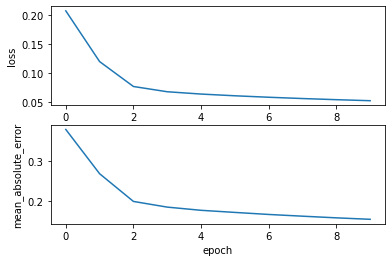

In [26]:
plt.subplot(2,1,1)
plt.plot(fit_RNN.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(fit_RNN.history['mean_absolute_error'])
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')

Compared to our previous models, the major difference both in the ouptut and the input (the code) is the absence of validation (or testing) data. One reason for that is because keras is very restrictive on RNNs and imposes that both the training and testing samples share the same dimensions. In our situation this is obviously not the case, hence we must bypass this obstacle by duplicating the model.


In [27]:
new_model = Sequential()
new_model.add(layers.GRU(16,
                         batch_input_shape= [nb_stocks,int(nb_dates_test),nb_feats ],                         
                         activation="tanh",
                         return_sequences = True
                        )
           )
new_model.add(layers.Dense(1))
new_model.set_weights(fit_RNN.model.get_weights())


Finally, once the new model is ready - and with the matching dimensions, we can push forward to predicting the test values. We resort to the predict() function and immediately compute the hit ratio obtained by the model.


In [28]:
pred_rnn = new_model.predict(test_features_rnn ,batch_size = nb_stocks)
print("Hit ratio:", (pred_rnn* test_labels_rnn > 0 ).mean() )


Hit ratio: 0.505158775650579
